# PhsioNet Dataset

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib

## CT Scans

In [2]:
path = 'C:\\Users\\ASUS\\Downloads\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\ct_scans'
img = nib.load('049.nii')

In [5]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  3 512 512  39   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.41210938  0.41210938  5.          0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2914
glmin           : -1024
descrip         : b'time=--------------.---;'
aux_file        : b';SIEMENS;Head_SAFIRE'
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : -0.0

In [30]:
hdr.get_xyzt_units()

('mm', 'unknown')

In [6]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(512, 512, 39)


In [7]:
print(img_data)

[[[-995. -993. -996. ... -994. -992. -990.]
  [-995. -995. -996. ... -995. -993. -993.]
  [-995. -996. -996. ... -995. -996. -994.]
  ...
  [-996. -996. -995. ... -992. -993. -992.]
  [-995. -996. -993. ... -991. -992. -992.]
  [-996. -996. -994. ... -991. -991. -992.]]

 [[-996. -994. -996. ... -995. -993. -991.]
  [-996. -995. -996. ... -995. -995. -993.]
  [-996. -996. -996. ... -995. -997. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -992.]
  [-996. -996. -992. ... -991. -992. -993.]
  [-996. -996. -994. ... -990. -990. -992.]]

 [[-996. -996. -997. ... -995. -994. -992.]
  [-996. -996. -996. ... -995. -996. -993.]
  [-996. -996. -996. ... -996. -996. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -993.]
  [-996. -996. -993. ... -990. -994. -994.]
  [-996. -996. -995. ... -990. -992. -993.]]

 ...

 [[-991. -994. -997. ... -998. -998. -996.]
  [-992. -995. -998. ... -998. -998. -997.]
  [-991. -996. -998. ... -998. -997. -998.]
  ...
  [-994. -997. -998. ... -990. -990. -99

In [31]:
mid_slice_x = img_data[35, :, :]
print(mid_slice_x.shape)

(512, 39)


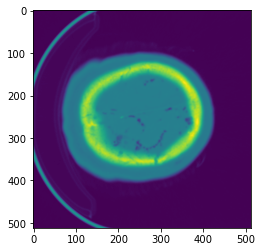

In [39]:
plt.imshow(img_data[:,:,30])

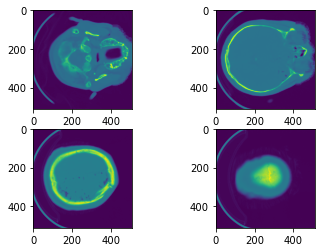

In [46]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_data[:,:,4])
axarr[0,1].imshow(img_data[:,:,16])
axarr[1,0].imshow(img_data[:,:,28])
axarr[1,1].imshow(img_data[:,:,33])

## Segmentation

In [61]:
path_seg = 'C:\\Users\\ASUS\\Downloads\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\masks\\049.nii'
img_seg = nib.load(path_seg)

In [62]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img_seg.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  3 512 512  39   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.41210938  0.41210938  5.          0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2914
glmin           : -1024
descrip         : b'time=--------------.---;'
aux_file        : b';SIEMENS;Head_SAFIRE'
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : -0.0

In [63]:
img_data_seg = img_seg.get_fdata()
print(type(img_data_seg))  # it's a numpy array!
print(img_data_seg.shape)

<class 'numpy.ndarray'>
(512, 512, 39)


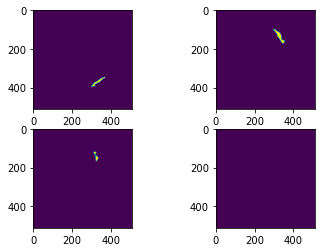

In [72]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_data_seg[:,:,21])
axarr[0,1].imshow(img_data_seg[:,:,16])
axarr[1,0].imshow(img_data_seg[:,:,13])
axarr[1,1].imshow(img_data_seg[:,:,33])

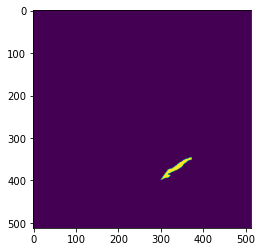

In [66]:
plt.imshow(img_data_seg[:,:,21])

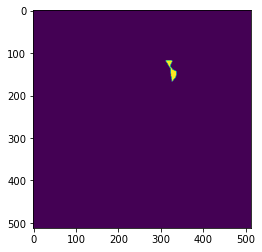

In [74]:
plt.imshow(img_data_seg[:,:,13])

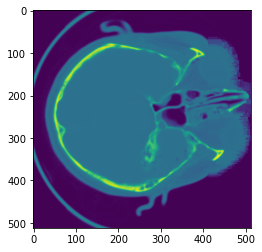

In [73]:
plt.imshow(img_data[:,:,13])

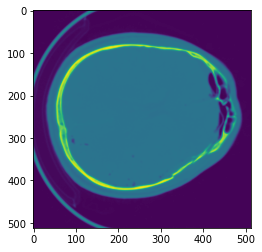

In [67]:
plt.imshow(img_data[:,:,21])